In [22]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [23]:
class Panel:
    def __init__(self, xa, ya, xb, yb, sigma):
        #Start and end points
        self.xa, self.xb = xa, xb
        self.ya, self.yb = ya, yb
        
        #Center and length
        self.xc, self.yc = 0.5*(xa+xb), 0.5*(ya+yb)
        self.length = math.sqrt((xb-xa)**2 + (yb-ya)**2)
        
        #Panel strength
        self.strength = sigma
        
        #Define panel orientation
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:    
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
            
        #Define normal vectors
        self.normx = yb-ya
        self.normy = xa-xb
        
        #Define tangent vectors
        self.tanx = xb-xa
        self.tany = yb-ya
            
        self.sigma = sigma
        self.vn = 0.
        self.vt = 0.
        self.cp = 0.

In [24]:
def get_source_panel_velocity(Xg, Yg, p):
    
    x_p =  math.sin(p.beta)*(Xg-p.xb) - math.cos(p.beta)*(Yg-p.yb)
    y_p =  math.cos(p.beta)*(Xg-p.xb) + math.sin(p.beta)*(Yg-p.yb)
    
    u_p = p.sigma/(4*math.pi)*numpy.log((x_p**2+y_p**2)/((x_p-p.length)**2+y_p**2))
    v_p = p.sigma/(2*math.pi)*(numpy.arctan2(y_p,x_p-p.length) - numpy.arctan2(y_p,x_p))
    
    u =  math.sin(p.beta)*u_p + math.cos(p.beta)*v_p
    v = -math.cos(p.beta)*u_p + math.sin(p.beta)*v_p
    
    return u, v

In [25]:
#Define geometry for circle:

R = 1.0
theta = numpy.linspace(0, 2.0*math.pi, 100)
xcyl, ycyl = R*numpy.cos(theta), R*numpy.sin(theta)

#Define number of panels:
N_panels = 30

# defining the end-points of the panels
xend = R*numpy.cos(numpy.linspace(0, 2*math.pi, N_panels+1))
yend = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

#Strength of panels:
sigma = 1.0

#Define panels:
panels = numpy.empty(N_panels,dtype = object)
for i in range (N_panels):
    panels[i] = Panel(xend[i], yend[i], xend[i+1], yend[i+1], sigma)

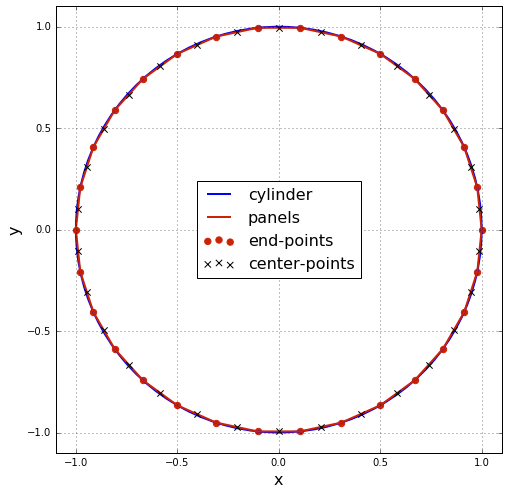

In [26]:
# plotting the panels
size = 8
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(xcyl, ycyl, color='b', linestyle='-', linewidth=2)
pyplot.plot(xend, yend, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', marker='x',s=40, zorder=3)
pyplot.legend(['cylinder', 'panels', 'end-points', 'center-points'], 
           loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

In [53]:
A = numpy.zeros((N_panels,N_panels)); b = numpy.zeros(N_panels); uinf = 1.0

for i in range (N_panels):
    panels[i].vn = 0.0
    xpi = panels[i].xc; ypi = panels[i].yc
    betap = panels[i].beta
    for j in range (N_panels):
        if (i != j):
            [up, vp]     = get_source_panel_velocity(xpi, ypi, panels[j])
            panels[i].vn = panels[i].vn + math.cos(betap)*(up) + math.sin(betap)*(vp)
            A[i,j]       = math.cos(betap)*(up) + math.sin(betap)*(vp)
        else:
            panels[i].vn = panels[i].vn + panels[i].sigma/2.0
            A[i,i] = panels[i].sigma/2.0
            
    b[i] = uinf*math.cos(betap)
    #print(xpi, ypi, b[i])
    
xsigma = numpy.linalg.solve(A,b)

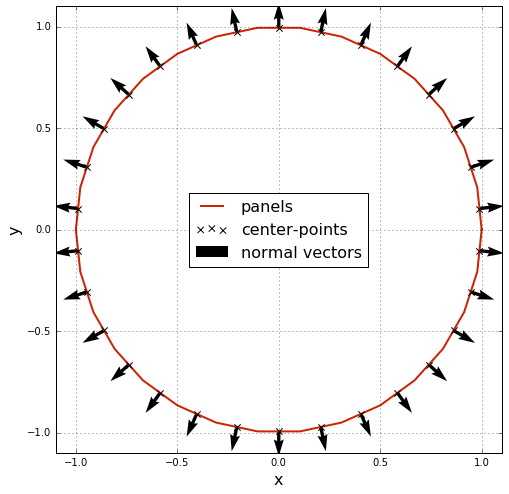

In [54]:
# plotting the panels
size = 8
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(xend, yend, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', marker='x',s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], \
[p.vn*math.cos(p.beta) for p in panels], [p.vn*math.sin(p.beta) for p in panels] )
pyplot.legend(['panels', 'center-points', 'normal vectors'], 
           loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

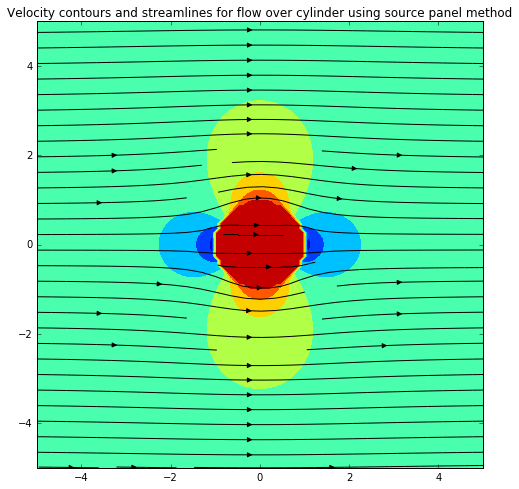

In [64]:
N = 100; uinf = 2.0
x = numpy.linspace(-5.0, 5.0, N); y = numpy.linspace(-5.0, 5.0, N)
X, Y = numpy.meshgrid(x,y)

xvel = numpy.zeros_like(X); yvel = numpy.zeros_like(X);

for ip in range(N_panels):
    panels[ip].sigma = -1.0*xsigma[ip];
    xp = panels[ip].xc; yp = panels[ip].yc; 
    for i in range (N):
        for j in range (N):
            [dxvel, dyvel] = get_source_panel_velocity(X[i,j], Y[i,j], panels[ip])
            xvel[i,j] = xvel[i,j] + dxvel; 
            yvel[i,j] = yvel[i,j] + dyvel;

xvel = xvel + uinf

pyplot.figure(figsize=(8,8))
pyplot.xlim(-5,5)
pyplot.ylim(-5,5)
pyplot.title('Velocity contours and streamlines for flow over cylinder using source panel method')
pyplot.contourf(X, Y, numpy.sqrt(xvel**2 + yvel**2))
pyplot.streamplot(X, Y, xvel, yvel, color = '#000000')